In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
import FinanceDataReader as fdr
import datetime

In [3]:
def loadStockData(companyName, startDate, endDate):
    symbol = str(df_kospi.loc[df_kospi['Name'] == companyName]['Symbol'].values[0])
    df_stock = fdr.DataReader(symbol, startDate.isoformat(), endDate.isoformat())
    df_stock = df_stock[['Close']]
    df_stock['Fluctuation'] = df_stock['Close'].div(df_stock['Close'].shift(1)).apply(lambda x : (x - 1) * 100)
    return df_stock

In [4]:
df_kospi = fdr.StockListing('KOSPI')

startDate = datetime.date(2020, 1, 1) # inclusive
endDate = datetime.date(2020, 1, 11) # inclusive

df_stock = loadStockData('삼성전자', startDate - datetime.timedelta(days=1), endDate)

In [5]:
df_stock

,Close,Fluctuation
Date,,
2020-01-02,55200,NaN
2020-01-03,55500,0.543478
2020-01-06,55500,0.000000
2020-01-07,55800,0.540541
2020-01-08,56800,1.792115
2020-01-09,58600,3.169014
2020-01-10,59500,1.535836


In [6]:
#LSTM 주가 예측 시작

samsung = fdr.DataReader('001460')
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['Day'] = samsung.index.day
samsung.tail()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2021-11-29,414500,442500,413500,440000,727,0.034078,2021,11,29
2021-11-30,446000,446500,419000,419000,223,-0.047727,2021,11,30
2021-12-01,443500,443500,413500,418500,384,-0.001193,2021,12,1
2021-12-02,418500,420000,413500,417500,207,-0.002389,2021,12,2
2021-12-03,413500,437500,413500,437500,1291,0.047904,2021,12,3


Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


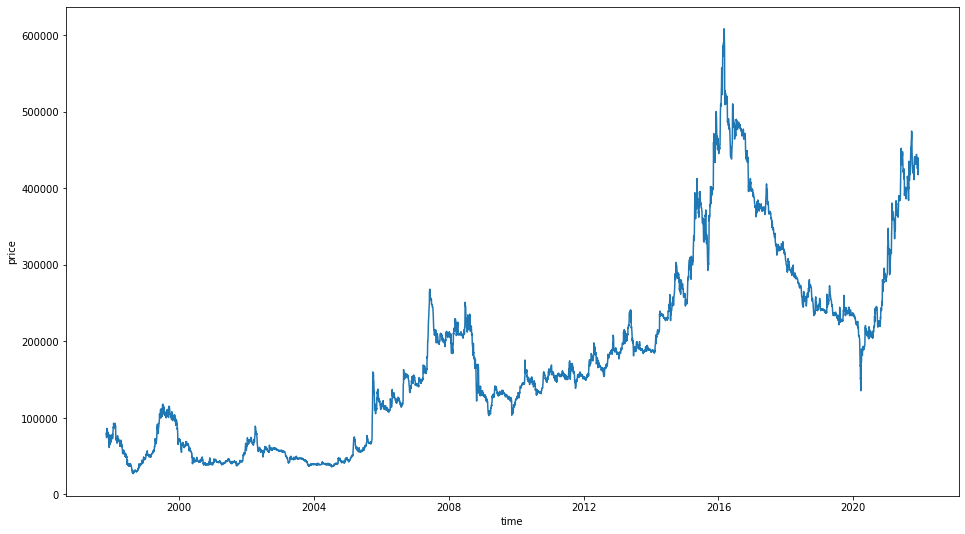

In [7]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=samsung['Close'], x=samsung.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


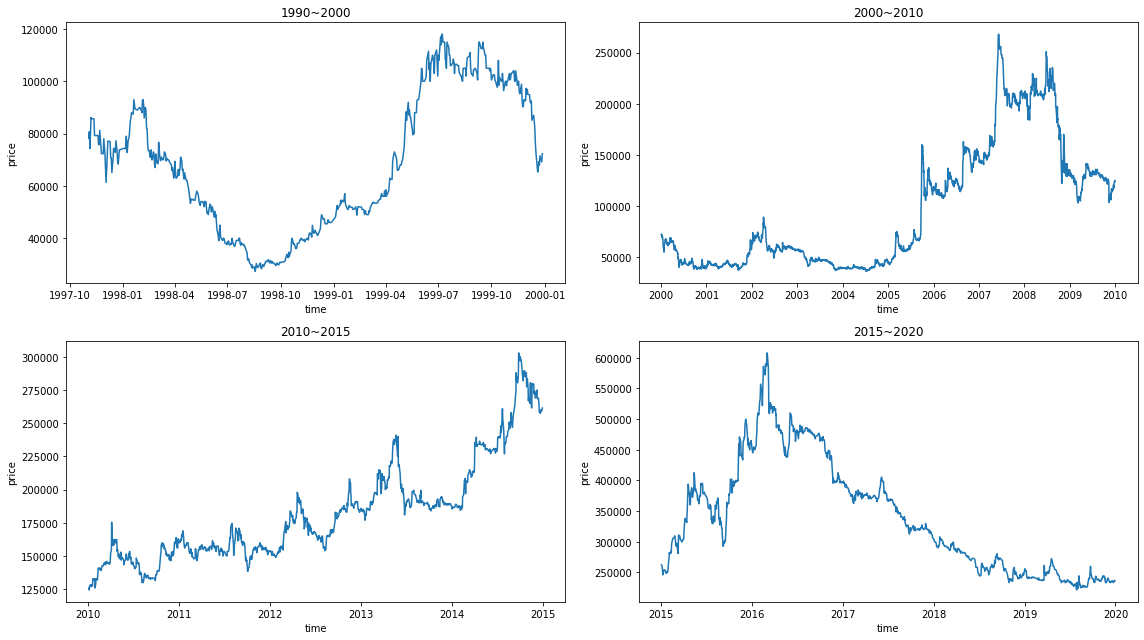

In [8]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])
scaled

array([[8.64134306e-02, 8.40836450e-02, 8.83613664e-02, 8.77509902e-02,
        0.00000000e+00],
       [9.06121757e-02, 8.82930976e-02, 9.26547598e-02, 9.20165318e-02,
        4.39299756e-04],
       [7.96930643e-02, 7.73461408e-02, 8.14895093e-02, 8.09281901e-02,
        8.74206515e-02],
       ...,
       [7.05782601e-01, 7.05032302e-01, 6.69672273e-01, 6.73669709e-01,
        8.43455532e-03],
       [6.63388163e-01, 6.65079905e-01, 6.69672273e-01, 6.71947649e-01,
        4.54675248e-03],
       [6.54909276e-01, 6.94831690e-01, 6.69672273e-01, 7.06388841e-01,
        2.83567993e-02]])

In [10]:
df = pd.DataFrame(scaled, columns=scale_cols)
df

,Open,High,Low,Close,Volume
0,0.086413,0.084084,0.088361,0.087751,0.000000
1,0.090612,0.088293,0.092655,0.092017,0.000439
2,0.079693,0.077346,0.081490,0.080928,0.087421
3,0.084733,0.087283,0.086643,0.090992,0.002855
4,0.099852,0.097557,0.102103,0.101398,0.086981
...,...,...,...,...,...
5995,0.656605,0.703332,0.669672,0.710694,0.015969
5996,0.710022,0.710133,0.679209,0.674531,0.004898
5997,0.705783,0.705032,0.669672,0.673670,0.008435
5998,0.663388,0.665080,0.669672,0.671948,0.004547


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.4, random_state=0, shuffle=False)

In [12]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0, shuffle=False)

In [13]:
y_test

4800    0.626313
4801    0.621147
4802    0.621147
4803    0.621147
4804    0.621147
          ...   
5995    0.710694
5996    0.674531
5997    0.673670
5998    0.671948
5999    0.706389
Name: Close, Length: 1200, dtype: float64

In [14]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

2021-12-03 13:55:38.168979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 13:55:38.169000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [16]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
validate_data = windowed_dataset(y_val, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

2021-12-03 13:55:44.565119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-03 13:55:44.565589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 13:55:44.565658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-03 13:55:44.565722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-03 13:55:44.567740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [17]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [19]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [20]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [21]:
history = model.fit(train_data, 
                    validation_data=(validate_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    110/Unknown - 2s 5ms/step - loss: 6.9432e-04 - mse: 0.0014
Epoch 00001: val_loss improved from inf to 0.00079, saving model to tmp/ckeckpointer.ckpt
112/112 [==============================] - 2s 11ms/step - loss: 6.8432e-04 - mse: 0.0014 - val_loss: 7.8864e-04 - val_mse: 0.0016
Epoch 2/50
102/112 [==========================>...] - ETA: 0s - loss: 7.6482e-05 - mse: 1.5296e-04
Epoch 00002: val_loss did not improve from 0.00079
112/112 [==============================] - 1s 6ms/step - loss: 7.5126e-05 - mse: 1.5025e-04 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 3/50
102/112 [==========================>...] - ETA: 0s - loss: 7.2385e-05 - mse: 1.4477e-04
Epoch 00003: val_loss did not improve from 0.00079
112/112 [==============================] - 1s 6ms/step - loss: 7.2368e-05 - mse: 1.4474e-04 - val_loss: 9.4300e-04 - val_mse: 0.0019
Epoch 4/50
102/112 [==========================>...] - ETA: 0s - loss: 6.3352e-05 - mse: 1.2670e-04
Epoch 00004: val_loss did not improve from 0.

In [22]:
model.load_weights(filename)

In [27]:
pred = model.predict(test_data)

myzeros = np.zeros((pred.shape[0],5))
newpred = pred + myzeros
price_pred = scaler.inverse_transform(newpred)
price_pred = price_pred[:,3:4]
print(price_pred.shape)
print(price_pred)

myreal = np.asarray(y_test)
newreal = myreal.reshape(-1,1)
myzeros2 = np.zeros((newreal.shape[0],5))
newpred2 = newreal + myzeros2
price_pred_real = scaler.inverse_transform(newpred2)

price_pred_real = price_pred_real[:,3:4]
print(price_pred_real)

(1180, 1)
[[360612.93977499]
 [360814.93784189]
 [361945.41400075]
 ...
 [415904.1649282 ]
 [412105.31368852]
 [410532.83696175]]
[[391000.]
 [388000.]
 [388000.]
 ...
 [418500.]
 [417500.]
 [437500.]]


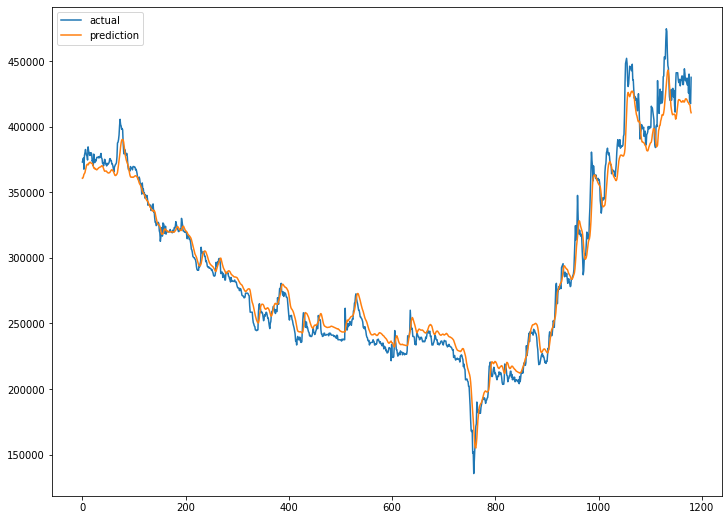

In [26]:
plt.figure(figsize=(12, 9))
#plt.plot(np.asarray(y_test)[20:], label='actual')
#plt.plot(pred, label='prediction')
plt.plot(price_pred_real[20:], label='actual')
plt.plot(price_pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
def loadStockData(companyName, startDate, endDate):
    symbol = str(df_kospi.loc[df_kospi['Name'] == companyName]['Symbol'].values[0])
    df_stock = fdr.DataReader(symbol, startDate.isoformat(), endDate.isoformat())
    df_stock = df_stock[['Close']]
    df_stock['Fluctuation'] = df_stock['Close'].div(df_stock['Close'].shift(1)).apply(lambda x : (x - 1) * 100)
    return df_stock

In [ ]:
def applyModel(companyName, predictDate):
    symbol = str(df_kospi.loc[df_kospi['Name'] == companyName]['Symbol'].values[0])
    df_stock = fdr.DataReader(symbol, startDate.isoformat(), endDate.isoformat())
    df_stock = df_stock[['Close']]
    df_stock['Fluctuation'] = df_stock['Close'].div(df_stock['Close'].shift(1)).apply(lambda x : (x - 1) * 100)
    return df_stock

In [ ]:
df_kospi = fdr.StockListing('KOSPI')

startDate = datetime.date(2020, 1, 1) # inclusive
endDate = datetime.date(2020, 1, 11) # inclusive

df_stock = loadStockData('삼성전자', startDate - datetime.timedelta(days=1), endDate)

predict_Date = datetime.date(2020 , 1, 1) #주가 예측을 원하는 날짜
predict_Company = '삼성전자' #주가 예측을 원하는 기업

predicted_price = applyModel(predict_Company, predict_Date)